# Kaggle : New York City Taxi Trip Duration
### Share code and data to improve ride time predictions

https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels

# 1 EDA (Exploratory Data Analysis)

# purpose of  EDA

- Suggest hypotheses about the causes of observed phenomena
- Assess assumptions on which statistical inference will be based
- Support the selection of appropriate statistical tools and techniques
- Provide a basis for further data collection through surveys or experiments

# EDA methods
- Graphical techniques used in EDA are:
    - boxplot 
        - detailed feature (datetime by month, day of week, hours)
    - historgram or barplot (distribution) # bin = range of value
        - origin feature (pick lat,long, drop lat, long, duration, passenger count, flag)
        - detailed feature (datetime by month, day of week, hours)
    - scatter plot
        - duration vs distance = to check odd data
    - Parallel Coordinates vs Colormaps vs Andrews curves charts
    - odd ratio????

- Quantative methods:
    - Trimean == tukey method?

# 1.1 Understanding data 

In [142]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import seaborn as sns
import ipyleaflet
from math import sin, cos, sqrt, atan2, radians
import folium
import folium.plugins as plugins
import os
from folium.plugins import MarkerCluster     # Map
from geographiclib.geodesic import Geodesic  # Map
import time, datetime                        # time data
import calendar
import scipy


%matplotlib inline


# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import statsmodels.api as sm
from sklearn.datasets import make_blobs

In [143]:
train = pd.read_csv("~/Documents/data/taxi_data/train.csv")
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [144]:
test = pd.read_csv("~/Documents/data/taxi_data/test.csv")
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


# 1.1.a Data type and unit

# unit

### latitude / longtitude = decimal degree (111.32mm per 0.000001°)
- ex) 40.767937 / -73.982155

### duration = sec
- ex) 455 sec = 7min 35sec

### vendor_id = 1, 2

### passenger_count = 0,,,,9

In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [101]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [102]:
# train.describe()

In [103]:
9.594923e+02

959.4923

### Sampling

In [145]:
np.random.seed(2)
train = train.sample(frac=0.001, replace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 100879 to 843651
Data columns (total 11 columns):
id                    1459 non-null object
vendor_id             1459 non-null int64
pickup_datetime       1459 non-null object
dropoff_datetime      1459 non-null object
passenger_count       1459 non-null int64
pickup_longitude      1459 non-null float64
pickup_latitude       1459 non-null float64
dropoff_longitude     1459 non-null float64
dropoff_latitude      1459 non-null float64
store_and_fwd_flag    1459 non-null object
trip_duration         1459 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 136.8+ KB


In [146]:
np.random.seed(2)
test = test.sample(frac=0.001, replace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 100879 to 291576
Data columns (total 9 columns):
id                    625 non-null object
vendor_id             625 non-null int64
pickup_datetime       625 non-null object
passenger_count       625 non-null int64
pickup_longitude      625 non-null float64
pickup_latitude       625 non-null float64
dropoff_longitude     625 non-null float64
dropoff_latitude      625 non-null float64
store_and_fwd_flag    625 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 48.8+ KB


# 1.1.b Missing Data check

In [106]:
#none of missing data
train2 = train.dropna(how = 'any')

len(train) == len(train2)

True

In [107]:
#none of missing data
test2 = test.dropna(how = 'any')

len(test) == len(test2)

True

### NYC Taxi Trip Duration [Train data]는

### 총 1,458,644 Row와 11 Column으로 구성되어 있으며,

### Missing Data는 존재하지 않습니다.

# 1.1.c Column information

- id : 개별 Taxi에 부여된 고유 id (이건 그냥 쓴거예요...)
- verdor_id : Taxi Company id >>>  1, 2로 구성되어 있는걸로 봐서 2개의 회사를 대상
- pickup/dropoff datetime : 출발/도착 시간정보 >> 년, 월, 일, 시각 정보가 포함
- passenger_count : 승객수 >>> 0~9명까지 존재
- pickup/dropoff_longitude & latitude : 출발/도착 지리정보
- store_and_fwd_flag : whether the trip data was sent immediately to the vendor (“N”) or held in the memory of the taxi because there was no connection to the server (“Y”)
- trip_duration : 탑승시간 >>> 단위는 Seconds

# 1.2 Feature Engineering & Data Cleaning

### 1.2.a Add columns with detailed informations


- duration per min
- datetime per hour
- datetime per day of week
- datetime per month

# drop "dropoff_datetime" column

In [147]:
train = train.drop("dropoff_datetime", axis=1)

In [148]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 100879 to 843651
Data columns (total 10 columns):
id                    1459 non-null object
vendor_id             1459 non-null int64
pickup_datetime       1459 non-null object
passenger_count       1459 non-null int64
pickup_longitude      1459 non-null float64
pickup_latitude       1459 non-null float64
dropoff_longitude     1459 non-null float64
dropoff_latitude      1459 non-null float64
store_and_fwd_flag    1459 non-null object
trip_duration         1459 non-null int64
dtypes: float64(4), int64(3), object(3)
memory usage: 125.4+ KB


In [149]:
#data type convert to datetime from object
train["pickup_datetime"] =  pd.to_datetime(train["pickup_datetime"])
# train["dropoff_datetime"] =  pd.to_datetime(train["dropoff_datetime"])

In [150]:
#data type convert to datetime from object
#not exist dropoff data
test["pickup_datetime"] =  pd.to_datetime(test["pickup_datetime"])

In [151]:
#day of week
#Monday=0, Sunday=6
train["pick_dayofweek"] = train["pickup_datetime"].dt.dayofweek
# train["drop_dayofweek"] = train["dropoff_datetime"].dt.dayofweek.astype("int")

#date by month
train["pick_dayofmonth"] = train["pickup_datetime"].dt.month
# train["drop_dayofmonth"] = train["dropoff_datetime"].dt.month.astype("int")

# #date by hour
train["pick_datehour"] = train["pickup_datetime"].dt.hour
# # train["drop_datehour"] = train["dropoff_datetime"].dt.hour.astype("int")

In [152]:
# #date time convert to sec
# train["pickup_sec"] = train["pickup_datetime"] - train["pick_dayofweek"]

In [153]:
#day of week
#Monday=0, Sunday=6
test["pick_dayofweek"] = test["pickup_datetime"].dt.dayofweek

#date by month
test["pick_dayofmonth"] = test["pickup_datetime"].dt.month

#date by hour
test["pick_datehour"] = test["pickup_datetime"].dt.hour

# 1.2.b Distance between pickup and dropoff location

In [154]:
# approximate radius of earth in km
R = 6371.0

dist = []

for i in range(len(train)):
    lat1 = radians(train.iloc[i,5])
    lon1 = radians(train.iloc[i,4])
    lat2 = radians(train.iloc[i,7])
    lon2 = radians(train.iloc[i,6])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    dist.append(distance)
    
train['distance'] = dist

In [155]:
# approximate radius of earth in km
R = 6371.0

dist = []

for i in range(len(test)):
    lat1 = radians(test.iloc[i,5])
    lon1 = radians(test.iloc[i,4])
    lat2 = radians(test.iloc[i,7])
    lon2 = radians(test.iloc[i,6])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    dist.append(distance)
    
test['distance'] = dist

# 1.2.c Outlier Removal

In [156]:
#outlier IQR method
#out of 75 percent value
train_1 = pd.DataFrame.quantile(train, q = 0.75)
train_1

#out of 25 percent value
train_3 = pd.DataFrame.quantile(train, q = 0.25)
train_3

iqr = train_3 - train_1
iqr

lower_bound = train_1 - (iqr * 1.5)
upper_bound = train_3 + (iqr * 1.5)

In [157]:
#removal outliers by IQR method
#time data has not been modified
train = train[train['pickup_longitude'] <= lower_bound["pickup_longitude"]]
train = train[train['pickup_longitude'] >= upper_bound["pickup_longitude"]]
train = train[train['pickup_latitude'] <= lower_bound["pickup_latitude"]]
train = train[train['pickup_latitude'] >= upper_bound["pickup_latitude"]]
train = train[train['dropoff_longitude'] <= lower_bound["dropoff_longitude"]]
train = train[train['dropoff_longitude'] >= upper_bound["dropoff_longitude"]]
train = train[train['dropoff_latitude'] <= lower_bound["dropoff_latitude"]]
train = train[train['dropoff_latitude'] >= upper_bound["dropoff_latitude"]]
train = train[train['trip_duration'] <= lower_bound["trip_duration"]]
train = train[train['trip_duration'] >= upper_bound["trip_duration"]]
train = train[train['distance'] <= lower_bound["distance"]]
train = train[train['distance'] >= upper_bound["distance"]]

In [158]:
#outlier IQR method
#out of 75 percent value
test_1 = pd.DataFrame.quantile(test, q = 0.75)
test_1

#out of 25 percent value
test_3 = pd.DataFrame.quantile(test, q = 0.25)
test_3

iqr = test_3 - test_1
iqr

lower_bound = test_1 - (iqr * 1.5)
upper_bound = test_3 + (iqr * 1.5)

In [159]:
#removal outliers by IQR method
#time data has not been modified
test = test[test['pickup_longitude'] <= lower_bound["pickup_longitude"]]
test = test[test['pickup_longitude'] >= upper_bound["pickup_longitude"]]
test = test[test['pickup_latitude'] <= lower_bound["pickup_latitude"]]
test = test[test['pickup_latitude'] >= upper_bound["pickup_latitude"]]
test = test[test['dropoff_longitude'] <= lower_bound["dropoff_longitude"]]
test = test[test['dropoff_longitude'] >= upper_bound["dropoff_longitude"]]
test = test[test['dropoff_latitude'] <= lower_bound["dropoff_latitude"]]
test = test[test['dropoff_latitude'] >= upper_bound["dropoff_latitude"]]
test = test[test['distance'] <= lower_bound["distance"]]
test = test[test['distance'] >= upper_bound["distance"]]

# ##categorical data convert encoding

In [94]:
# train = pd.get_dummies(train, columns=["store_and_fwd_flag"], prefix='store_and_fwd_flag')
# train = pd.get_dummies(train, columns=["pick_datehour"], prefix='pick_datehour')
# train = pd.get_dummies(train, columns=["pick_dayofweek"], prefix='pick_dayofweek')
# train = pd.get_dummies(train, columns=["pick_dayofmonth"], prefix='pick_dayofmonth')
# train.info()

In [95]:
# test = pd.get_dummies(test, columns=["store_and_fwd_flag"], prefix='store_and_fwd_flag')
# test = pd.get_dummies(test, columns=["pick_datehour"], prefix='pick_datehour')
# test = pd.get_dummies(test, columns=["pick_dayofweek"], prefix='pick_dayofweek')
# test = pd.get_dummies(test, columns=["pick_dayofmonth"], prefix='pick_dayofmonth')
# test.info()

In [96]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,...,pick_dayofweek_3,pick_dayofweek_4,pick_dayofweek_5,pick_dayofweek_6,pick_dayofmonth_1,pick_dayofmonth_2,pick_dayofmonth_3,pick_dayofmonth_4,pick_dayofmonth_5,pick_dayofmonth_6
100879,id0673821,2,2016-03-19 20:53:44,2,-73.990944,40.732998,-73.944931,40.774727,1467,6.045803,...,0,0,1,0,0,0,1,0,0,0
203245,id3465534,2,2016-04-25 14:31:34,2,-73.982185,40.752148,-73.988281,40.742992,331,1.140205,...,0,0,0,0,0,0,0,1,0,0
1133010,id1354600,1,2016-05-04 16:35:10,1,-73.969307,40.760986,-73.978966,40.747524,357,1.703721,...,0,0,0,0,0,0,0,0,1,0
1102498,id0962434,1,2016-01-14 04:30:56,1,-73.981865,40.758327,-73.991219,40.750141,221,1.203892,...,1,0,0,0,1,0,0,0,0,0
557489,id1750356,2,2016-06-07 08:09:01,6,-73.959686,40.808899,-73.975456,40.764610,1838,5.100504,...,0,0,0,0,0,0,0,0,0,1


# 1.2.d Indivisual feature visualization

- boxplot
- histogram
- jointplot

# y value = % of value

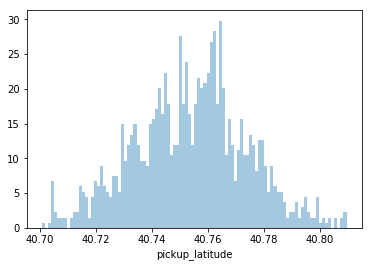

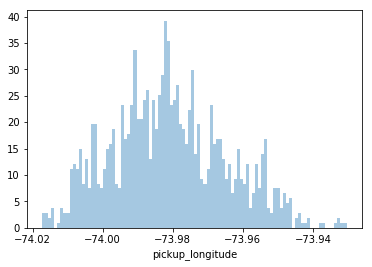

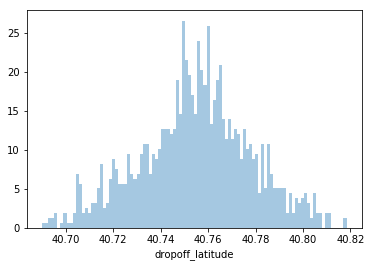

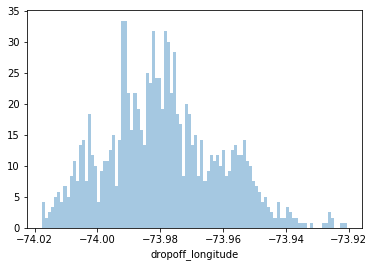

In [28]:
#taxi location latitude, longitude distribution
ax1 = sns.distplot(train["pickup_latitude"], bins = 100, kde=False, norm_hist=True);
plt.xlabel('pickup_latitude')
plt.show()

ax2 = sns.distplot(train["pickup_longitude"], bins = 100, kde=False, norm_hist=True);
plt.xlabel('pickup_longitude')
plt.show()

ax3 = sns.distplot(train["dropoff_latitude"], bins = 100, kde=False, norm_hist=True);
plt.xlabel('dropoff_latitude')
plt.show()

ax4 = sns.distplot(train["dropoff_longitude"], bins = 100, kde=False, norm_hist=True);
plt.xlabel('dropoff_longitude')
plt.show()

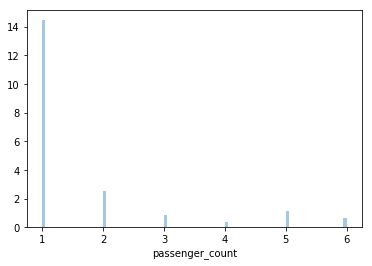

In [29]:
#passenger count
ax1 = sns.distplot(train["passenger_count"], bins = 100, kde=False, norm_hist=True);
plt.xlabel('passenger_count')
plt.show()

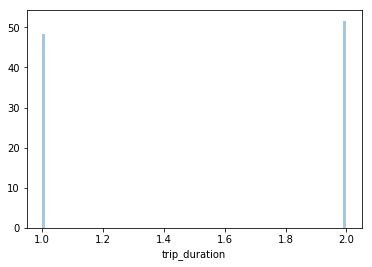

In [30]:
#duration
ax1 = sns.distplot(train["vendor_id"], bins=100, kde=False, norm_hist=True);
plt.xlabel('trip_duration')
plt.show()

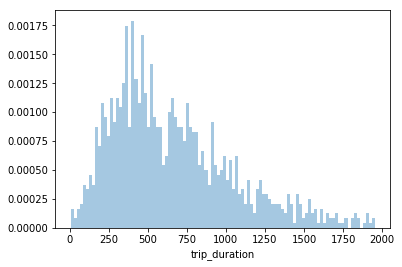

In [31]:
#duration
ax1 = sns.distplot(train["trip_duration"], bins=100, kde=False, norm_hist=True);
plt.xlabel('trip_duration')
plt.show()

In [51]:
#pick day of week boxplot
ax1 = sns.boxplot(train,  train["trip_duration"],hue= prefix["store_and_fwd_flag"], palette= 'Set2')
plt.show()

NameError: name 'prefix' is not defined

In [32]:
#pick day of week boxplot
ax1 = sns.boxplot(train,  train["trip_duration"],hue="store_and_fwd_flag" palette= 'Set2')
ax2 = sns.swarmplot(train["pick_dayofweek"],  train["trip_duration"], color="0.25", alpha=.5)
plt.show()

KeyError: 'pick_dayofweek'

In [33]:
#pick hours boxplot
fig = plt.figure(figsize=(15,5))
ax1 = sns.boxplot(train["pick_datehour"],  train["trip_duration"], palette= 'Set2')
ax2 = sns.swarmplot(train["pick_datehour"],  train["trip_duration"],  color="0.25", alpha=.5)
plt.show()

KeyError: 'pick_datehour'

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


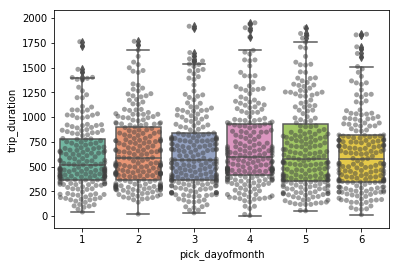

In [37]:
#pick month boxplot
ax1 = sns.boxplot(train["pick_dayofmonth"],  train["trip_duration"], palette= 'Set2')
ax2 = sns.swarmplot(train["pick_dayofmonth"],  train["trip_duration"],  color="0.25", alpha=.5)
plt.show()

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


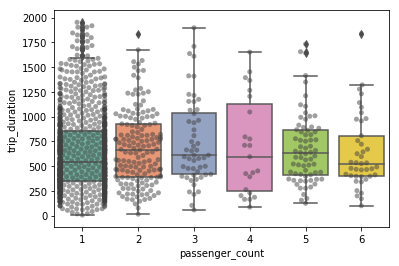

In [38]:
#pick passenger count boxplot
ax1 = sns.boxplot(train["passenger_count"],  train["trip_duration"], palette= 'Set2')
ax2 = sns.swarmplot(train["passenger_count"],  train["trip_duration"],  color="0.25", alpha=.5)
plt.show()

/home/jk/enter/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


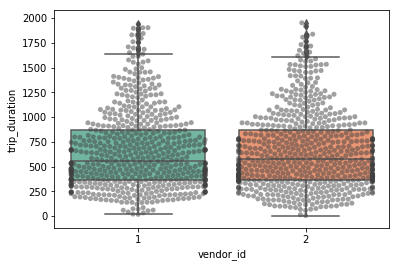

In [39]:
#pick vendor id boxplot
ax1 = sns.boxplot(train["vendor_id"],  train["trip_duration"], palette= 'Set2')
ax2 = sns.swarmplot(train["vendor_id"],  train["trip_duration"], color="0.25", alpha=.5)
plt.show()

In [101]:
# #pick store boxplot
# ax1 = sns.boxplot(train["store_and_fwd_flag_N", "store_and_fwd_flag_Y"],  train["trip_duration"], palette= 'Set2')
# ax2 = sns.swarmplot(train["store_and_fwd_flag_N", "store_and_fwd_flag_Y"],  train["trip_duration"], color="0.25", alpha=.5)
# plt.show()

In [ ]:
 ## distance와 trip_duration의 jointplot
ax1 = sns.jointplot(train['distance'], train['trip_duration'], kind = 'reg')
plt.show()

# 1.2.d Map Visualization

- locate data onto NYC map (pickup location)

In [29]:
# interactive map visualization
# pick location and count data on the map
#center location
center=[np.mean(train['pickup_latitude']), np.mean(train['pickup_longitude'])]

m = folium.Map(location = center, zoom_start=10, tiles = 'stamentoner')

marker_cluster = MarkerCluster(
    name='1000 clustered icons',
    overlay=True,
    control=False,
    icon_create_function=None
)

for i in range(len(train)):
    location1=[train.iloc[i, 5], train.iloc[i, 4]]
    folium.CircleMarker(
        location=location1,
        radius=1,
        color = "blue"
      ).add_to(m)
    marker = folium.Marker(location=location1)
    marker_cluster.add_child(marker)
    marker_cluster.add_to(m)
    
m

# 1.3 EDA Interpretation & conclusion

# modeling

In [124]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544 entries, 203245 to 291576
Data columns (total 13 columns):
id                    544 non-null object
vendor_id             544 non-null int64
pickup_datetime       544 non-null datetime64[ns]
passenger_count       544 non-null int64
pickup_longitude      544 non-null float64
pickup_latitude       544 non-null float64
dropoff_longitude     544 non-null float64
dropoff_latitude      544 non-null float64
store_and_fwd_flag    544 non-null object
pick_dayofweek        544 non-null int64
pick_dayofmonth       544 non-null int64
pick_datehour         544 non-null int64
distance              544 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(5), object(2)
memory usage: 59.5+ KB


In [179]:
train = pd.get_dummies(train, columns=["store_and_fwd_flag"], prefix='store_and_fwd_flag')
test = pd.get_dummies(test, columns=["store_and_fwd_flag"], prefix='store_and_fwd_flag')

In [180]:
X_train = train.drop(labels = ["id", "trip_duration", "pickup_datetime", ], axis=1)
Y_train = train["trip_duration"]
X_test  = test.drop(labels = ["id", "pickup_datetime", ], axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((1234, 12), (1234,), (544, 12))

In [181]:
import statsmodels.api as sm
from sklearn.datasets import make_blobs

OLS_model = sm.OLS(Y_train, X_train).fit()
print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     115.0
Date:                Sat, 03 Mar 2018   Prob (F-statistic):          8.13e-180
Time:                        16:32:41   Log-Likelihood:                -8671.5
No. Observations:                1234   AIC:                         1.737e+04
Df Residuals:                    1222   BIC:                         1.743e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
vendor_id              -12.0130 

In [182]:
from sklearn.metrics import mean_squared_error

In [183]:
# mean_squared_error(Y_train, Y_test) 

In [184]:
import statsmodels


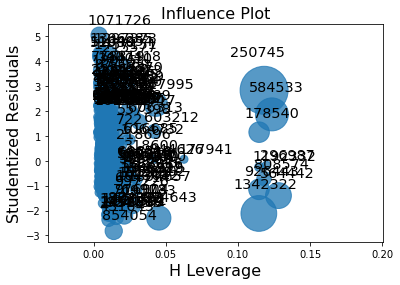

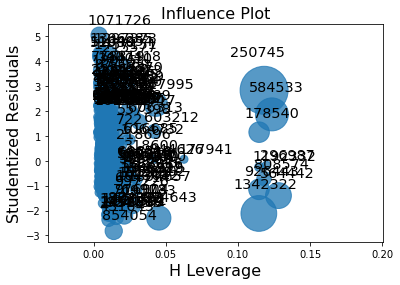

In [185]:
#influence plot
statsmodels.graphics.regressionplots.influence_plot(OLS_model, criterion='cooks')

In [186]:

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

import numpy as np
import pandas as pd
import scipy

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [187]:
Y_test = OLS_model.predict(X_test)
Y_test.head(), len(Y_test)

(203245    1163.862951
 620104     342.687858
 437782     282.015555
 84434      265.717348
 558155     389.443627
 dtype: float64, 544)

# model validation score

# RMSLE

In [188]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


In [189]:
Y_train1 = OLS_model.predict(X_train)
Y_train1.head(), len(Y_train1)

(100879     1280.651925
 203245      507.486881
 1133010     603.554269
 1102498     456.396830
 557489     1293.770425
 dtype: float64, 1234)

In [190]:
rmsle(Y_train, Y_train1)

272.6543370201073

# kaggle data submission

In [169]:
# sub = pd.DataFrame()
# sub['Id'] = test["id"]
# sub['trip_duration'] = Y_test
# sub.to_csv('submission_sample.csv',index=False)

# ridge

In [62]:

>>>
>>> from sklearn.linear_model import Ridge
>>> import numpy as np

clf = Ridge(alpha=1.0)

In [63]:
clf.fit(X_train, Y_train) 

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [72]:
from sklearn.linear_model import Ridge
    #Fit the model
ridgereg = Ridge(normalize=True)
ridgereg.fit(X_train, Y_train)
y_pred = ridgereg.predict(X_test)
    

In [74]:
len(y_pred)

544

In [ ]:


    #Return the result in pre-defined format
rss = sum((y_pred - Y_train)**2)
ret = [rss]
ret.extend([ridgereg.intercept_])
ret.extend(ridgereg.coef_)
    

(100879     1246.099331
 203245      560.923062
 1133010     714.240959
 1102498     227.111347
 557489     1369.188706
 dtype: float64, 1234)

254.67625658694774

In [87]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
               [4, 2], [4, 4], [4, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_
kmeans.predict([[0, 0], [4, 4]])
kmeans.cluster_centers_


array([[1., 2.],
       [4., 2.]])

In [92]:
KMeans.fit(X, y=None)

TypeError: fit() missing 1 required positional argument: 'X'